# Neural Architecture Search and Deep Ensemble with Uncertainty Quantification for Regression (Pytorch)

In this tutorial, you will learn how to perform **Neural Architecture Search (NAS)** and use it to construct a diverse deep ensemble while disentangling **aleatoric** and **epistemic **uncertainty**.

NAS is a technique for automatically exploring and optimizing the architecture of deep neural networks to solve a given task. Here, we will use **hyperparameter optimization (HPO)** algorithms to guide the NAS process.

Specifically, you will learn how to:
1.	**Define a customizable PyTorch module** that exposes neural architecture hyperparameters.
2.	**Constrain the hyperparameter search space** to reduce redundancies and improve efficiency by breaking symmetry in the search space.

This tutorial will provide a hands-on approach to leveraging NAS for robust regression models with well-calibrated uncertainty estimates.

In [1]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split


WIDTH_PLOTS = 8
HEIGHT_PLOTS = WIDTH_PLOTS / 1.618

## Dataset

We generate synthetic data from a 1D scalar function $Y = f(X) + \epsilon(X)$, where $X,Y$ are random variables with support $\mathbb{R}$.

The training data are drown uniformly from $X \sim U([-30,-15] \cup [15,30])$.

$$ f(x) = \cos(x/2) + 2 \cdot \sin(x/10) + x/100$$

and $\epsilon(X) \sim \mathcal{N}(0, \sigma(X))$ with:
- $\sigma(x) = 0.5$ if $x \in [-30,-15]$
- $\sigma(x) = 1$ if $x \in [15,30]$

In [100]:
def load_data(
    developement_size=500, test_size=200, random_state=42, x_min=-50, x_max=50
):
    rs = np.random.RandomState(random_state)

    def f(x):
        return np.cos(x / 2) + 2 * np.sin(x / 10) + x / 100

    x_1 = rs.uniform(low=-30, high=-15.0, size=developement_size // 2)
    eps_1 = rs.normal(loc=0.0, scale=0.5, size=developement_size // 2)
    y_1 = f(x_1) + eps_1

    x_2 = rs.uniform(low=15.0, high=30.0, size=developement_size // 2)
    eps_2 = rs.normal(loc=0.0, scale=1.0, size=developement_size // 2)
    y_2 = f(x_2) + eps_2

    x = np.concatenate([x_1, x_2], axis=0)
    y = np.concatenate([y_1, y_2], axis=0)

    test_X = np.linspace(x_min, x_max, test_size)
    test_y = f(test_X)

    x = x.reshape(-1, 1)
    y = y.reshape(-1, 1)

    train_X, valid_X, train_y, valid_y = train_test_split(
        x, y, test_size=0.33, random_state=random_state
    )

    test_X = test_X.reshape(-1, 1)
    test_y = test_y.reshape(-1, 1)

    return (train_X, train_y), (valid_X, valid_y), (test_X, test_y)


(train_X, train_y), (valid_X, valid_y), (test_X, test_y) = load_data()

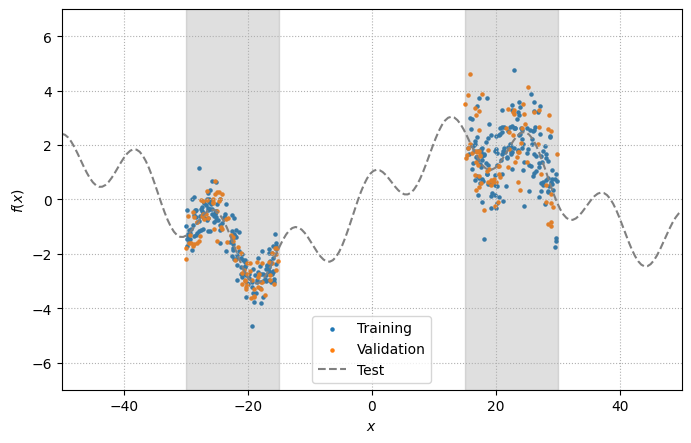

In [101]:
plt.figure(figsize=(WIDTH_PLOTS, HEIGHT_PLOTS))
plt.scatter(train_X, train_y, s=5, label="Training")
plt.scatter(valid_X, valid_y, s=5, label="Validation")
plt.plot(test_X, test_y, linestyle="--", color="gray", label="Test")

x_lim, y_lim = 50, 7
plt.fill_between([-30, -15], [-y_lim, -y_lim], [y_lim, y_lim], color="gray", alpha=0.25)
plt.fill_between([15, 30], [-y_lim, -y_lim], [y_lim, y_lim], color="gray", alpha=0.25)
plt.xlim(-x_lim, x_lim)
plt.ylim(-y_lim, y_lim)
plt.legend()
plt.xlabel(r"$x$")
plt.ylabel(r"$f(x)$")
plt.grid(which="both", linestyle=":")
plt.show()

## Configurable Deep Neural Network with Aleatoric Uncertainty

Then, we define a configurable Pytorch module to explore: the number of layers, the number of units per layer, the activation function per layer, and the dropout rate. The output of this module will be a Gaussian distribution $\mathcal{N}(\mu_\theta(x), \sigma_\theta(x))$, where $\theta$ represent the concatenation of weights and hyperparameters of our model.

In [92]:
import torch
import torch.nn as nn

from torch.utils.data import DataLoader, TensorDataset

In [5]:
class DeepNormalRegressor(nn.Module):
    def __init__(self, n_inputs, layers, loc=0, scale=1.0):
        super().__init__()

        layers_ = []
        prev_n_units = n_inputs
        for n_units, activation, dropout_rate in layers:
            linear_layer = nn.Linear(prev_n_units, n_units)
            if activation == "relu":
                activation_layer = nn.ReLU()
            elif activation == "sigmoid":
                activation_layer = nn.Sigmoid()
            elif activation == "tanh":
                activation_layer = nn.Tanh()
            elif activation == "swish":
                activation_layer = nn.SiLU()
            elif activation == "mish":
                activation_layer = nn.Mish()
            elif activation == "gelu":
                activation_layer = nn.GELU()
            elif activation == "silu":
                activation_layer = nn.SiLU()
            dropout_layer = nn.Dropout(dropout_rate)

            layers_.extend([linear_layer, activation_layer, dropout_layer])

            prev_n_units = n_units

        # Shared parameters
        self.shared_layer = nn.Sequential(
            *layers_,
        )

        # Mean parameters
        self.mean_layer = nn.Sequential(
            nn.Linear(prev_n_units, prev_n_units),
            nn.ReLU(),
            nn.Linear(prev_n_units, 1),
        )

        # Standard deviation parameters
        self.std_layer = nn.Sequential(
            nn.Linear(prev_n_units, prev_n_units),
            nn.ReLU(),
            nn.Linear(prev_n_units, 1),
            nn.Softplus(),  # enforces positivity
        )

        self.loc = loc
        self.scale = scale

    def forward(self, x):
        # Shared embedding
        shared = self.shared_layer(x)

        # Parametrization of the mean
        mu = self.mean_layer(shared) + self.loc

        # Parametrization of the standard deviation
        sigma = self.std_layer(shared) * self.scale

        return torch.distributions.Normal(mu, sigma)


## Neural Architecture Search Space

In [6]:
from ConfigSpace import GreaterThanCondition
from deephyper.hpo import HpProblem


def create_hpo_problem(max_num_layers=10):
    problem = HpProblem()

    num_layers = problem.add_hyperparameter(
        (1, max_num_layers), "num_layers", default_value=5
    )

    conditions = []
    for i in range(max_num_layers):
        layer_i_units = problem.add_hyperparameter(
            (1, 200), f"layer_{i}_units", default_value=64
        )
        layer_i_activation = problem.add_hyperparameter(
            ["relu", "sigmoid", "tanh", "swish", "mish", "gelu", "silu"],
            f"layer_{i}_activation",
            default_value="relu",
        )
        layer_i_dropout_rate = problem.add_hyperparameter(
            (0.0, 0.5), f"layer_{i}_dropout_rate", default_value=0.0
        )

        if i > 0:
            conditions.extend(
                [
                    GreaterThanCondition(layer_i_units, num_layers, i),
                    GreaterThanCondition(layer_i_activation, num_layers, i),
                    GreaterThanCondition(layer_i_dropout_rate, num_layers, i),
                ]
            )

    problem.add_conditions(conditions)

    problem.add_hyperparameter(
        (1e-5, 1e-1, "log-uniform"), "learning_rate", default_value=2e-3
    )
    problem.add_hyperparameter((1, 100, "log-uniform"), "batch_size", default_value=32)

    return problem


In [7]:
problem = create_hpo_problem()
problem

Configuration space object:
  Hyperparameters:
    batch_size, Type: UniformInteger, Range: [1, 100], Default: 32, on log-scale
    layer_0_activation, Type: Categorical, Choices: {relu, sigmoid, tanh, swish, mish, gelu, silu}, Default: relu
    layer_0_dropout_rate, Type: UniformFloat, Range: [0.0, 0.5], Default: 0.0
    layer_0_units, Type: UniformInteger, Range: [1, 200], Default: 64
    layer_1_activation, Type: Categorical, Choices: {relu, sigmoid, tanh, swish, mish, gelu, silu}, Default: relu
    layer_1_dropout_rate, Type: UniformFloat, Range: [0.0, 0.5], Default: 0.0
    layer_1_units, Type: UniformInteger, Range: [1, 200], Default: 64
    layer_2_activation, Type: Categorical, Choices: {relu, sigmoid, tanh, swish, mish, gelu, silu}, Default: relu
    layer_2_dropout_rate, Type: UniformFloat, Range: [0.0, 0.5], Default: 0.0
    layer_2_units, Type: UniformInteger, Range: [1, 200], Default: 64
    layer_3_activation, Type: Categorical, Choices: {relu, sigmoid, tanh, swish, mish,

## Loss and Metric

In [8]:
def nll(y, rv_y):
    """Negative log likelihood for Pytorch distribution.

    Args:
        y: true data.
        rv_y: learned (predicted) probability distribution.
    """
    return -rv_y.log_prob(y)


def squared_error(y_true, rv_y):
    """Squared error for Pytorch distribution.

    Args:
        y: true data.
        rv_y: learned (predicted) probability distribution.
    """
    y_pred = rv_y.mean
    return (y_true - y_pred) ** 2

## Training Loop

In [16]:
from tqdm.notebook import tqdm


def train_one_step(model, optimizer, x_batch, y_batch):
    model.train()
    optimizer.zero_grad()
    y_dist = model(x_batch)

    loss = torch.mean(nll(y_batch, y_dist))
    mse = torch.mean(squared_error(y_batch, y_dist))

    loss.backward()
    optimizer.step()

    return loss, mse


def train(
    model,
    optimizer,
    x_train,
    x_val,
    y_train,
    y_val,
    n_epochs,
    batch_size,
    scheduler=None,
    patience=100,
    progressbar=True,
):
    data_train = DataLoader(
        TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True
    )

    train_loss, val_loss = [], []
    train_mse, val_mse = [], []

    tqdm_bar = tqdm(total=n_epochs, disable=not progressbar)

    for epoch in range(n_epochs):
        batch_losses_t, batch_losses_v, batch_mse_t, batch_mse_v = [], [], [], []

        for batch_x, batch_y in data_train:
            b_train_loss, b_train_mse = train_one_step(
                model, optimizer, batch_x, batch_y
            )

            model.eval()
            y_dist = model(x_val)
            b_val_loss = torch.mean(nll(y_val, y_dist))
            b_val_mse = torch.mean(squared_error(y_val, y_dist))

            batch_losses_t.append(b_train_loss.detach().numpy())
            batch_mse_t.append(b_train_mse.detach().numpy())
            batch_losses_v.append(b_val_loss.detach().numpy())
            batch_mse_v.append(b_val_mse.detach().numpy())

        train_loss.append(np.mean(batch_losses_t))
        val_loss.append(np.mean(batch_losses_v))
        train_mse.append(np.mean(batch_mse_t))
        val_mse.append(np.mean(batch_mse_v))

        if scheduler is not None:
            scheduler.step(val_loss[-1])

        tqdm_bar.update(1)
        tqdm_bar.set_postfix(
            {
                "train_loss": f"{train_loss[-1]:.3f}",
                "val_loss": f"{val_loss[-1]:.3f}",
                "train_mse": f"{train_mse[-1]:.3f}",
                "val_mse": f"{val_mse[-1]:.3f}",
            }
        )

        if len(val_loss) > (patience + 1) and val_loss[-patience - 1] < min(
            val_loss[-patience:]
        ):
            break

    return train_loss, val_loss, train_mse, val_mse

## Evaluation Function

In [17]:
def run(job, model_checkpoint_dir=".", verbose=False):
    (x, y), (vx, vy), (tx, ty) = load_data()

    y_mu = np.mean(y)
    y_std = np.std(y)

    inputs = x.shape[1]

    num_layers = job.parameters["num_layers"]
    model = DeepNormalRegressor(
        inputs,
        layers=[
            (
                job.parameters[f"layer_{i}_units"],
                job.parameters[f"layer_{i}_activation"],
                job.parameters[f"layer_{i}_dropout_rate"],
            )
            for i in range(num_layers)
        ],
        loc=y_mu,
        scale=y_std,
    )

    if verbose:
        print(model)

    optimizer = torch.optim.Adam(model.parameters(), lr=job.parameters["learning_rate"])
    # scheduler = None
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=50)

    x = torch.from_numpy(x).float()
    vx = torch.from_numpy(vx).float()
    tx = torch.from_numpy(tx).float()

    y = torch.from_numpy(y).float()
    vy = torch.from_numpy(vy).float()
    ty = torch.from_numpy(ty).float()

    try:
        train_losses, val_losses, train_mse, val_mse = train(
            model,
            optimizer,
            x,
            vx,
            y,
            vy,
            n_epochs=1000,
            batch_size=job.parameters["batch_size"],
            scheduler=scheduler,
            progressbar=verbose,
        )
    except Exception:
        return "F_fit"

    ty_pred = model(tx)
    test_loss = torch.mean(nll(ty, ty_pred)).detach().numpy()
    test_mse = torch.mean(squared_error(ty, ty_pred)).detach().numpy()

    # Saving the model
    torch.save(
        model.state_dict(), os.path.join(model_checkpoint_dir, f"model_{job.id}.pt")
    )

    return {
        "objective": -val_losses[-1],
        "metadata": {
            "train_loss": train_losses,
            "val_loss": val_losses,
            "train_mse": train_mse,
            "val_mse": val_mse,
            "test_loss": test_loss,
            "test_mse": test_mse,
        },
    }

## Evaluation of the Baseline Neural Architecture

In [18]:
from deephyper.evaluator import RunningJob


def evaluate_baseline():
    model_checkpoint_dir = "nas_baseline_regression/models"
    pathlib.Path(model_checkpoint_dir).mkdir(parents=True, exist_ok=True)

    problem = create_hpo_problem()

    default_parameters = problem.default_configuration
    print(f"{default_parameters=}\n")

    result = run(
        RunningJob(parameters=default_parameters),
        model_checkpoint_dir=model_checkpoint_dir,
        verbose=True,
    )
    return result


In [19]:
baseline_results = evaluate_baseline()

default_parameters={'batch_size': 32, 'layer_0_activation': 'relu', 'layer_0_dropout_rate': 0.0, 'layer_0_units': 64, 'learning_rate': 0.002, 'num_layers': 5, 'layer_1_activation': 'relu', 'layer_1_dropout_rate': 0.0, 'layer_1_units': 64, 'layer_2_activation': 'relu', 'layer_2_dropout_rate': 0.0, 'layer_2_units': 64, 'layer_3_activation': 'relu', 'layer_3_dropout_rate': 0.0, 'layer_3_units': 64, 'layer_4_activation': 'relu', 'layer_4_dropout_rate': 0.0, 'layer_4_units': 64, 'layer_5_activation': 'relu', 'layer_5_dropout_rate': 0.0, 'layer_5_units': 1, 'layer_6_activation': 'relu', 'layer_6_dropout_rate': 0.0, 'layer_6_units': 1, 'layer_7_activation': 'relu', 'layer_7_dropout_rate': 0.0, 'layer_7_units': 1, 'layer_8_activation': 'relu', 'layer_8_dropout_rate': 0.0, 'layer_8_units': 1, 'layer_9_activation': 'relu', 'layer_9_dropout_rate': 0.0, 'layer_9_units': 1}

DeepNormalRegressor(
  (shared_layer): Sequential(
    (0): Linear(in_features=1, out_features=64, bias=True)
    (1): ReLU()

  0%|          | 0/1000 [00:00<?, ?it/s]

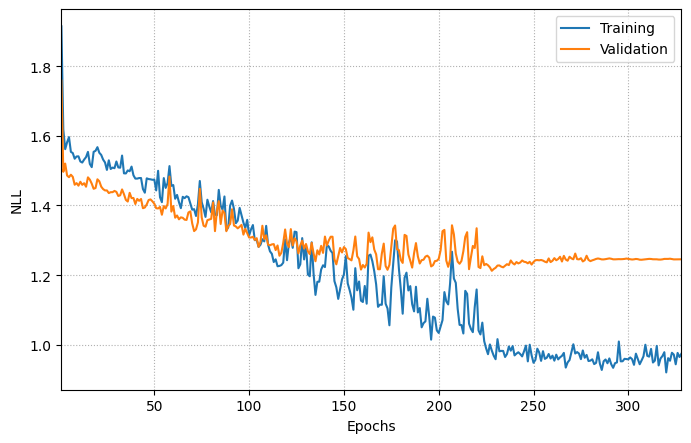

In [20]:
plt.figure(figsize=(WIDTH_PLOTS, HEIGHT_PLOTS))

x_values = np.arange(1, len(baseline_results["metadata"]["train_loss"]) + 1)
plt.plot(
    x_values,
    baseline_results["metadata"]["train_loss"],
    label="Training",
)
plt.plot(
    x_values,
    baseline_results["metadata"]["val_loss"],
    label="Validation",
)

plt.xlim(x_values.min(), x_values.max())
plt.grid(which="both", linestyle=":")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("NLL")
plt.show()

In [21]:
hpo_dir = "nas_baseline_regression"
model_checkpoint_dir = os.path.join(hpo_dir, "models")
file_name = "model_0.0.pt"

y_mu, y_std = np.mean(train_y), np.std(train_y)
inputs = train_X.shape[1]

weights_path = os.path.join(model_checkpoint_dir, file_name)
job_id = int(file_name[6:-3].split(".")[-1])

parameters = problem.default_configuration

num_layers = parameters["num_layers"]
torch_module = DeepNormalRegressor(
    inputs,
    layers=[
        (
            parameters[f"layer_{i}_units"],
            parameters[f"layer_{i}_activation"],
            parameters[f"layer_{i}_dropout_rate"],
        )
        for i in range(num_layers)
    ],
    loc=y_mu,
    scale=y_std,
)

torch_module.load_state_dict(torch.load(weights_path, weights_only=True))
torch_module.eval()

y_pred = torch_module.forward(torch.from_numpy(test_X).float())
y_pred_mean = y_pred.loc.detach().numpy()
y_pred_std = y_pred.scale.detach().numpy()

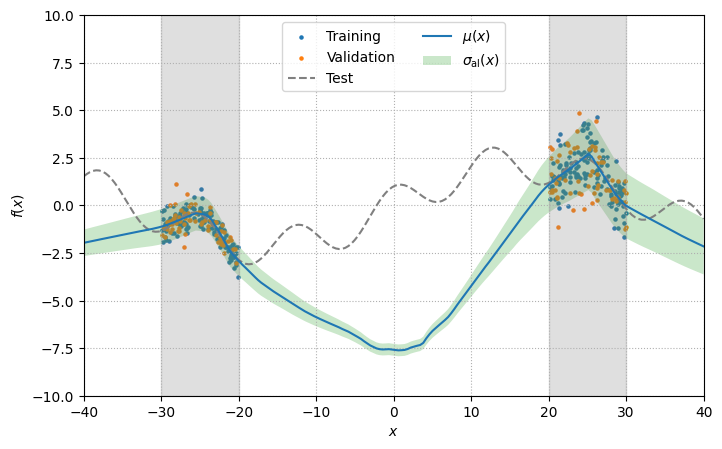

In [22]:
plt.figure(figsize=(WIDTH_PLOTS, HEIGHT_PLOTS))
plt.scatter(train_X, train_y, s=5, label="Training")
plt.scatter(valid_X, valid_y, s=5, label="Validation")
plt.plot(test_X, test_y, linestyle="--", color="gray", label="Test")

plt.plot(test_X, y_pred_mean, label=r"$\mu(x)$")
kappa = 1.96
plt.fill_between(
    test_X.reshape(-1),
    (y_pred_mean - kappa * y_pred_std).reshape(-1),
    (y_pred_mean + kappa * y_pred_std).reshape(-1),
    alpha=0.25,
    label=r"$\sigma_\text{al}(x)$",
)

x_lim, y_lim = 40, 10
plt.fill_between([-30, -20], [-y_lim, -y_lim], [y_lim, y_lim], color="gray", alpha=0.25)
plt.fill_between([20, 30], [-y_lim, -y_lim], [y_lim, y_lim], color="gray", alpha=0.25)
plt.xlim(-x_lim, x_lim)
plt.ylim(-y_lim, y_lim)
plt.legend(ncols=2)
plt.xlabel(r"$x$")
plt.ylabel(r"$f(x)$")
plt.grid(which="both", linestyle=":")
plt.show()

## Running the Neural Architecture Search

In [23]:
from deephyper.evaluator import Evaluator
from deephyper.evaluator.callback import TqdmCallback
from deephyper.hpo import CBO


def run_neural_architecture_search(problem):
    hpo_dir = "nas_regression"
    model_checkpoint_dir = os.path.join(hpo_dir, "models")
    pathlib.Path(model_checkpoint_dir).mkdir(parents=True, exist_ok=True)

    evaluator = Evaluator.create(
        run,
        method="ray",
        method_kwargs={
            "num_cpus": 8,
            "num_cpus_per_task": 1,
            "run_function_kwargs": {
                "model_checkpoint_dir": model_checkpoint_dir,
                "verbose": False,
            },
            "callbacks": [TqdmCallback()],
        },
    )

    search_kwargs = {
        "initial_points": [problem.default_configuration],
        "n_initial_points": 2 * len(problem) + 1,  # Number of initial random points
        "surrogate_model": "ET",  # Use Extra Trees as surrogate model
        "surrogate_model_kwargs": {
            "n_estimators": 50,  # Relatively small number of trees in the surrogate to make it "fast"
            "min_samples_split": 8,  # Larger number to avoid small leaf nodes (smoothing the response)
        },
        "multi_point_strategy": "qUCBd",  # Multi-point strategy for asynchronous batch generations (explained later)
        "acq_optimizer": "mixedga",  # Use continuous Genetic Algorithm for the acquisition function optimizer
        "acq_optimizer_freq": 1,  # Frequency of the acquisition function optimizer (1 = each new batch generation) increasing this value can help amortize the computational cost of acquisition function optimization
        "filter_duplicated": False,  # Deactivate filtration of duplicated new points
        "kappa": 10.0,  # Initial value of exploration-exploitation parameter for the acquisition function
        "scheduler": {  # Scheduler for the exploration-exploitation parameter "kappa"
            "type": "periodic-exp-decay",  # Periodic exponential decay
            "period": 50,  # Period over which the decay is applied. It is useful to escape local solutions.
            "kappa_final": 0.001,  # Value of kappa at the end of each "period"
        },
        "objective_scaler": "identity",
        "random_state": 42,  # Random seed
    }
    search = CBO(problem, evaluator, log_dir=hpo_dir, **search_kwargs)

    results = search.search(max_evals=200)

    return results

In [24]:
hpo_results = run_neural_architecture_search(problem)

2025-01-31 15:22:44,371	INFO worker.py:1819 -- Started a local Ray instance.
/Users/romainegele/Documents/Argonne/deephyper/src/deephyper/evaluator/_evaluator.py:148: UserWarning: Applying nest-asyncio patch for IPython Shell!
  warnings.warn("Applying nest-asyncio patch for IPython Shell!", category=UserWarning)


  0%|          | 0/200 [00:00<?, ?it/s]

## Analysing the Neural Architecture Search Results

In [26]:
import json

from deephyper.analysis.hpo import filter_failed_objectives
from deephyper.analysis.hpo import parameters_from_row
from deephyper.analysis.hpo import plot_search_trajectory_single_objective_hpo
from deephyper.analysis.hpo import plot_worker_utilization

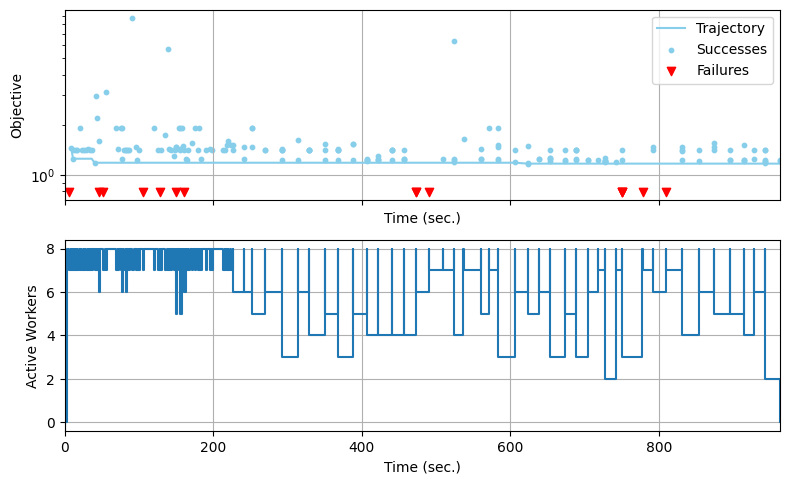

In [ ]:
fig, axes = plt.subplots(
    nrows=2,
    ncols=1,
    sharex=True,
    figsize=(WIDTH_PLOTS, HEIGHT_PLOTS),
)

plot_search_trajectory_single_objective_hpo(
    hpo_results,
    mode="min",
    x_units="seconds",
    ax=axes[0],
)
axes[0].set_yscale("log")

plot_worker_utilization(
    hpo_results,
    profile_type="submit/gather",
    ax=axes[1],
)

plt.tight_layout()
plt.show()

In [30]:
hpo_results, hpo_results_failed = filter_failed_objectives(hpo_results)

hpo_results

,p:batch_size,p:layer_0_activation,p:layer_0_dropout_rate,p:layer_0_units,p:learning_rate,p:num_layers,p:layer_1_activation,p:layer_1_dropout_rate,p:layer_1_units,p:layer_2_activation,...,job_id,job_status,m:timestamp_submit,m:train_loss,m:val_loss,m:train_mse,m:val_mse,m:test_loss,m:test_mse,m:timestamp_gather
1,36,swish,0.244056,19,0.008935,9,relu,0.174634,67,silu,...,1,DONE,2.846346,"[1.9056331, 1.6651711, 1.5905201, 1.5775468, 1...","[1.7772491, 1.5081491, 1.467396, 1.4975464, 1....","[2.4186354, 1.6462264, 1.4245632, 1.4055705, 1...","[1.8936129, 1.2644422, 1.1632447, 1.1769465, 1...",1.686805,1.502177,9.049607
2,32,relu,0.000000,64,0.002000,5,relu,0.000000,64,relu,...,0,DONE,2.844547,"[1.897477, 1.5885096, 1.6014835, 1.5418557, 1....","[1.7303349, 1.5538094, 1.4856824, 1.4712235, 1...","[2.399171, 1.436196, 1.4605362, 1.3662951, 1.4...","[1.8326541, 1.3594047, 1.2677432, 1.2617358, 1...",5.015194,2.284003,11.369305
3,18,gelu,0.019016,84,0.000776,6,relu,0.115452,87,tanh,...,8,DONE,8.300883,"[2.0679185, 1.9961888, 1.9721364, 1.8905823, 1...","[1.93095, 1.9263126, 1.8826795, 1.8023187, 1.5...","[3.1107821, 3.0468287, 2.9809816, 2.5772808, 1...","[2.6456048, 2.6028326, 2.5105956, 2.0962603, 1...",1.752627,1.620933,13.326577
4,17,tanh,0.155214,65,0.000789,9,swish,0.089041,158,silu,...,2,DONE,2.847874,"[2.0595398, 1.9717265, 1.6994705, 1.5716865, 1...","[1.9334996, 1.882425, 1.5982542, 1.4824877, 1....","[3.11905, 2.9894724, 1.7614956, 1.3600636, 1.3...","[2.649527, 2.5150735, 1.4493532, 1.2252018, 1....",1.740400,1.598429,15.442416
5,17,sigmoid,0.391268,83,0.001104,8,sigmoid,0.224998,199,silu,...,5,DONE,2.852217,"[2.0868654, 1.9900022, 1.9581226, 1.8569182, 1...","[1.9411345, 1.9058313, 1.8907591, 1.7727644, 1...","[3.0748358, 3.090867, 2.9318566, 2.2949374, 1....","[2.6464128, 2.6328175, 2.5103054, 1.9684076, 1...",1.765402,1.627726,17.226446
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197,12,tanh,0.276511,130,0.001849,3,mish,0.024946,50,silu,...,193,DONE,915.161413,"[1.6708446, 1.5597085, 1.5415771, 1.5261227, 1...","[1.5634465, 1.4577161, 1.4594018, 1.4187667, 1...","[1.5705551, 1.2882487, 1.277221, 1.2741654, 1....","[1.3247805, 1.1893921, 1.1481218, 1.1307551, 1...",2.239017,1.706091,942.624219
198,13,tanh,0.255124,107,0.003876,3,silu,0.035953,96,sigmoid,...,198,DONE,928.102554,"[1.7687731, 1.5564356, 1.5006864, 1.5158558, 1...","[1.6413412, 1.4568545, 1.4325445, 1.4264331, 1...","[1.7254896, 1.3494047, 1.22568, 1.2479433, 1.2...","[1.4319732, 1.131282, 1.1376951, 1.1392535, 1....",1.734612,1.578171,942.637021
199,14,tanh,0.228814,142,0.002184,3,swish,0.030148,49,silu,...,196,DONE,928.098798,"[1.7313753, 1.5525477, 1.5348809, 1.5952288, 1...","[1.5962622, 1.4535553, 1.4469303, 1.4846222, 1...","[1.796057, 1.3427224, 1.2665883, 1.4042943, 1....","[1.448951, 1.169376, 1.175611, 1.1620824, 1.18...",5.207595,3.248674,942.647147
200,14,tanh,0.261656,131,0.002140,3,gelu,0.035114,47,silu,...,200,DONE,942.579010,"[1.7735803, 1.5548097, 1.5526739, 1.5387019, 1...","[1.6567049, 1.503599, 1.4355661, 1.4468979, 1....","[1.7749002, 1.3020837, 1.3710788, 1.2698019, 1...","[1.5929592, 1.2325048, 1.1633823, 1.138037, 1....",2.068074,1.560524,963.046700


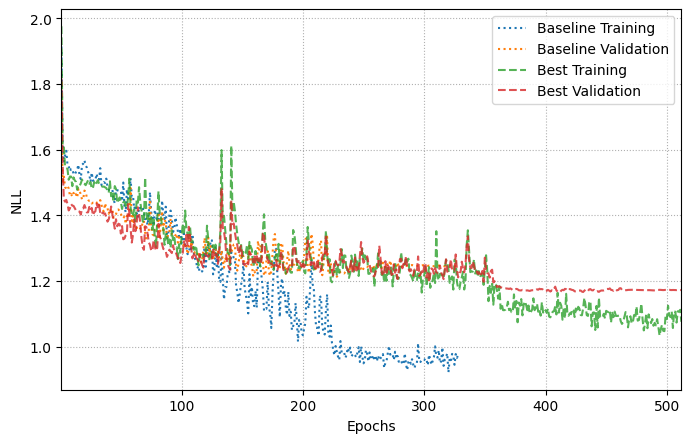

In [42]:
plt.figure(figsize=(WIDTH_PLOTS, HEIGHT_PLOTS))

x_values = np.arange(1, len(baseline_results["metadata"]["train_loss"]) + 1)
plt.plot(
    x_values,
    baseline_results["metadata"]["train_loss"],
    linestyle=":",
    label="Baseline Training",
)
plt.plot(
    x_values,
    baseline_results["metadata"]["val_loss"],
    linestyle=":",
    label="Baseline Validation",
)

i_max = hpo_results["objective"].argmax()
train_loss = json.loads(hpo_results.iloc[i_max]["m:train_loss"])
val_loss = json.loads(hpo_results.iloc[i_max]["m:val_loss"])

x_values = np.arange(1, len(train_loss) + 1)
plt.plot(
    x_values,
    train_loss,
    alpha=0.8,
    linestyle="--",
    label="Best Training",
)
plt.plot(
    x_values,
    val_loss,
    alpha=0.8,
    linestyle="--",
    label="Best Validation",
)
plt.xlim(x_values.min(), x_values.max())
plt.grid(which="both", linestyle=":")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("NLL")
plt.show()

In [43]:
hpo_dir = "nas_regression"
model_checkpoint_dir = os.path.join(hpo_dir, "models")
job_id = hpo_results.iloc[i_max]["job_id"]
file_name = f"model_0.{job_id}.pt"

y_mu, y_std = np.mean(train_y), np.std(train_y)
inputs = train_X.shape[1]

weights_path = os.path.join(model_checkpoint_dir, file_name)
parameters = parameters_from_row(hpo_results.iloc[i_max])

num_layers = parameters["num_layers"]
torch_module = DeepNormalRegressor(
    inputs,
    layers=[
        (
            parameters[f"layer_{i}_units"],
            parameters[f"layer_{i}_activation"],
            parameters[f"layer_{i}_dropout_rate"],
        )
        for i in range(num_layers)
    ],
    loc=y_mu,
    scale=y_std,
)

torch_module.load_state_dict(torch.load(weights_path, weights_only=True))
torch_module.eval()

y_pred = torch_module.forward(torch.from_numpy(test_X).float())
y_pred_mean = y_pred.loc.detach().numpy()
y_pred_std = y_pred.scale.detach().numpy()

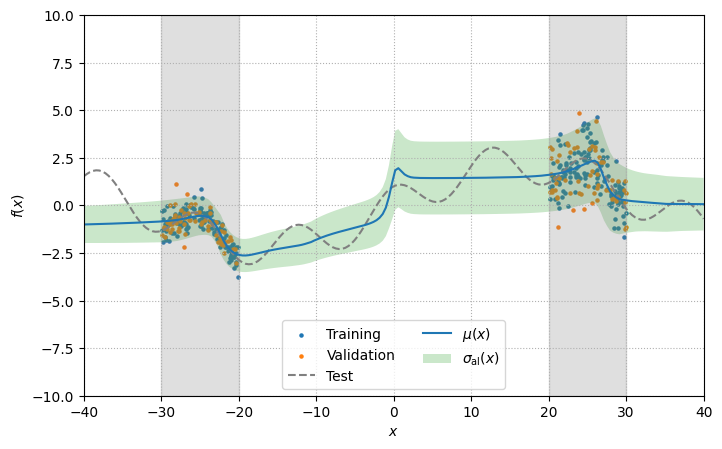

In [44]:
plt.figure(figsize=(WIDTH_PLOTS, HEIGHT_PLOTS))
plt.scatter(train_X, train_y, s=5, label="Training")
plt.scatter(valid_X, valid_y, s=5, label="Validation")
plt.plot(test_X, test_y, linestyle="--", color="gray", label="Test")

plt.plot(test_X, y_pred_mean, label=r"$\mu(x)$")
kappa = 1.96
plt.fill_between(
    test_X.reshape(-1),
    (y_pred_mean - kappa * y_pred_std).reshape(-1),
    (y_pred_mean + kappa * y_pred_std).reshape(-1),
    alpha=0.25,
    label=r"$\sigma_\text{al}(x)$",
)

x_lim, y_lim = 40, 10
plt.fill_between([-30, -20], [-y_lim, -y_lim], [y_lim, y_lim], color="gray", alpha=0.25)
plt.fill_between([20, 30], [-y_lim, -y_lim], [y_lim, y_lim], color="gray", alpha=0.25)
plt.xlim(-x_lim, x_lim)
plt.ylim(-y_lim, y_lim)
plt.legend(ncols=2)
plt.xlabel(r"$x$")
plt.ylabel(r"$f(x)$")
plt.grid(which="both", linestyle=":")
plt.show()

## Deep Ensemble

In [45]:
import os

from deephyper.ensemble import EnsemblePredictor
from deephyper.ensemble.aggregator import MixedNormalAggregator
from deephyper.ensemble.loss import NormalNegLogLikelihood
from deephyper.ensemble.selector import GreedySelector, TopKSelector
from deephyper.predictor.torch import TorchPredictor

In [46]:
class NormalTorchPredictor(TorchPredictor):
    def __init__(self, torch_module):
        super().__init__(torch_module)

    def pre_process_inputs(self, X):
        X = super().pre_process_inputs(X).float()
        return X

    def post_process_predictions(self, y):
        y = {
            "loc": y.loc.detach().numpy(),
            "scale": y.scale.detach().numpy(),
        }
        return y

In [47]:
hpo_dir = "nas_regression"
model_checkpoint_dir = os.path.join(hpo_dir, "models")

y_mu, y_std = np.mean(train_y), np.std(train_y)
inputs = train_X.shape[1]

y_predictors = []
job_id_predictors = []

for file_name in tqdm(os.listdir(model_checkpoint_dir)):
    if not file_name.endswith(".pt"):
        continue

    weights_path = os.path.join(model_checkpoint_dir, file_name)
    job_id = int(file_name[6:-3].split(".")[-1])

    row = hpo_results[hpo_results["job_id"] == job_id]
    if len(row) == 0:
        continue
    assert len(row) == 1
    row = row.iloc[0]
    parameters = parameters_from_row(row)

    num_layers = parameters["num_layers"]
    torch_module = DeepNormalRegressor(
        inputs,
        layers=[
            (
                parameters[f"layer_{i}_units"],
                parameters[f"layer_{i}_activation"],
                parameters[f"layer_{i}_dropout_rate"],
            )
            for i in range(num_layers)
        ],
        loc=y_mu,
        scale=y_std,
    )

    try:
        torch_module.load_state_dict(torch.load(weights_path, weights_only=True))
    except RuntimeError:
        continue

    torch_module.eval()

    predictor = NormalTorchPredictor(torch_module)
    y_pred = predictor.predict(valid_X)
    y_predictors.append(y_pred)
    job_id_predictors.append(job_id)

  0%|          | 0/203 [00:00<?, ?it/s]

In [88]:
k = 50

# Use TopK or Greedy/Caruana
# selector = TopKSelector(
#     loss_func=NormalNegLogLikelihood(),
#     k=k,
# )

selector = GreedySelector(
    loss_func=NormalNegLogLikelihood(),
    aggregator=MixedNormalAggregator(),
    k=k,
    max_it=100,
    k_init=3,
    early_stopping=False,
    with_replacement=True,
    bagging=True,
    verbose=True,
)

selected_predictors_indexes, selected_predictors_weights = selector.select(
    valid_y,
    y_predictors,
)

print(f"{selected_predictors_indexes=}")
print(f"{selected_predictors_weights=}")

selected_predictors_job_ids = np.array(job_id_predictors)[selected_predictors_indexes]
selected_predictors_job_ids

print(f"{selected_predictors_job_ids=}")

Ensemble initialized with [24, 141, 117]
Step 1, ensemble is [24, 141, 117, 182]
Step 2, ensemble is [24, 141, 117, 182, 24]
Step 3, ensemble is [24, 141, 117, 182, 24, 136]
Step 4, ensemble is [24, 141, 117, 182, 24, 136, 138]
Step 5, ensemble is [24, 141, 117, 182, 24, 136, 138, 24]
Step 6, ensemble is [24, 141, 117, 182, 24, 136, 138, 24, 24]
Step 7, ensemble is [24, 141, 117, 182, 24, 136, 138, 24, 24, 24]
Step 8, ensemble is [24, 141, 117, 182, 24, 136, 138, 24, 24, 24, 136]
Step 9, ensemble is [24, 141, 117, 182, 24, 136, 138, 24, 24, 24, 136, 24]
Step 10, ensemble is [24, 141, 117, 182, 24, 136, 138, 24, 24, 24, 136, 24, 73]
Step 11, ensemble is [24, 141, 117, 182, 24, 136, 138, 24, 24, 24, 136, 24, 73, 138]
Step 12, ensemble is [24, 141, 117, 182, 24, 136, 138, 24, 24, 24, 136, 24, 73, 138, 22]
Step 13, ensemble is [24, 141, 117, 182, 24, 136, 138, 24, 24, 24, 136, 24, 73, 138, 22, 138]
Step 14, ensemble is [24, 141, 117, 182, 24, 136, 138, 24, 24, 24, 136, 24, 73, 138, 22, 138

In [89]:
predictors = []

hpo_dir = "nas_regression"
model_checkpoint_dir = os.path.join(hpo_dir, "models")

y_mu, y_std = np.mean(train_y), np.std(train_y)
inputs = train_X.shape[1]

for job_id in selected_predictors_job_ids:
    file_name = f"model_0.{job_id}.pt"

    weights_path = os.path.join(model_checkpoint_dir, file_name)

    row = hpo_results[hpo_results["job_id"] == job_id].iloc[0]
    parameters = parameters_from_row(row)

    num_layers = parameters["num_layers"]
    torch_module = DeepNormalRegressor(
        inputs,
        layers=[
            (
                parameters[f"layer_{i}_units"],
                parameters[f"layer_{i}_activation"],
                parameters[f"layer_{i}_dropout_rate"],
            )
            for i in range(num_layers)
        ],
        loc=y_mu,
        scale=y_std,
    )

    torch_module.load_state_dict(torch.load(weights_path, weights_only=True))
    torch_module.eval()
    predictor = NormalTorchPredictor(torch_module)
    predictors.append(predictor)

ensemble = EnsemblePredictor(
    predictors=predictors,
    weights=selected_predictors_weights,
    aggregator=MixedNormalAggregator(decomposed_scale=True),
)

y_pred = ensemble.predict(test_X)

## Aleatoric Uncertainty

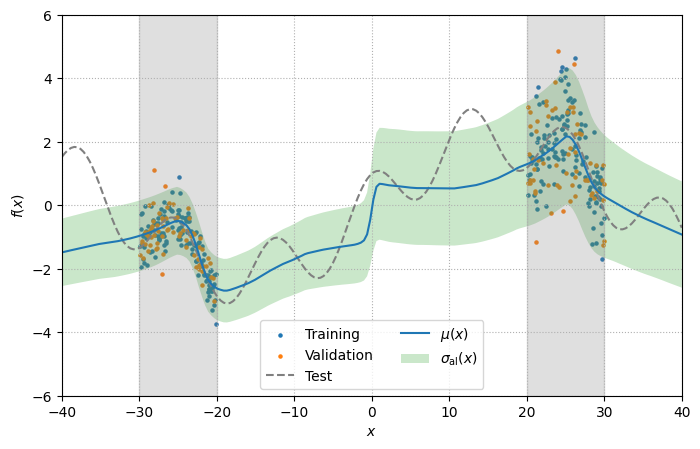

In [90]:
plt.figure(figsize=(WIDTH_PLOTS, HEIGHT_PLOTS))
plt.scatter(train_X, train_y, s=5, label="Training")
plt.scatter(valid_X, valid_y, s=5, label="Validation")
plt.plot(test_X, test_y, linestyle="--", color="gray", label="Test")

plt.plot(test_X, y_pred["loc"], label=r"$\mu(x)$")
kappa = 1.96
plt.fill_between(
    test_X.reshape(-1),
    (y_pred["loc"] - kappa * y_pred["scale_aleatoric"]).reshape(-1),
    (y_pred["loc"] + kappa * y_pred["scale_aleatoric"]).reshape(-1),
    alpha=0.25,
    label=r"$\sigma_\text{al}(x)$",
)

x_lim, y_lim = 40, 6
plt.fill_between([-30, -20], [-y_lim, -y_lim], [y_lim, y_lim], color="gray", alpha=0.25)
plt.fill_between([20, 30], [-y_lim, -y_lim], [y_lim, y_lim], color="gray", alpha=0.25)
plt.xlim(-x_lim, x_lim)
plt.ylim(-y_lim, y_lim)
plt.legend(ncols=2)
plt.xlabel(r"$x$")
plt.ylabel(r"$f(x)$")
plt.grid(which="both", linestyle=":")
plt.show()

## Epistemic Uncertainty

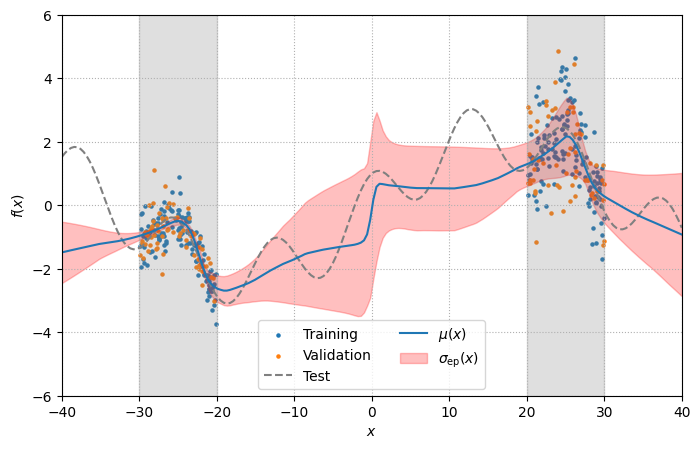

In [91]:
plt.figure(figsize=(WIDTH_PLOTS, HEIGHT_PLOTS))
plt.scatter(train_X, train_y, s=5, label="Training")
plt.scatter(valid_X, valid_y, s=5, label="Validation")
plt.plot(test_X, test_y, linestyle="--", color="gray", label="Test")

plt.plot(test_X, y_pred["loc"], label=r"$\mu(x)$")
kappa = 1.96
plt.fill_between(
    test_X.reshape(-1),
    (y_pred["loc"] - kappa * y_pred["scale_epistemic"]).reshape(-1),
    (y_pred["loc"] + kappa * y_pred["scale_epistemic"]).reshape(-1),
    alpha=0.25,
    color="red",
    label=r"$\sigma_\text{ep}(x)$",
)

x_lim, y_lim = 40, 6
plt.fill_between([-30, -20], [-y_lim, -y_lim], [y_lim, y_lim], color="gray", alpha=0.25)
plt.fill_between([20, 30], [-y_lim, -y_lim], [y_lim, y_lim], color="gray", alpha=0.25)
plt.xlim(-x_lim, x_lim)
plt.ylim(-y_lim, y_lim)
plt.legend(ncols=2)
plt.xlabel(r"$x$")
plt.ylabel(r"$f(x)$")
plt.grid(which="both", linestyle=":")
plt.show()